In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
#Set Parameters
im_width = 256
im_height = 256

In [5]:
import glob
import os

# Define the paths to image and mask directories
train_dir = "/content/drive/MyDrive/img _msk_red/images"
mask_dir = "/content/drive/MyDrive/img _msk_red/masks"

# Check if directories exist
if not os.path.exists(train_dir):
    print(f"Directory '{train_dir}' not found.")
    train_files = []
else:
    # Use glob to get all image files in train_dir
    train_files = glob.glob(os.path.join(train_dir, "*.png"))  # Adjust file extension as needed
    train_files = sorted(train_files)  # Sort the list of file paths

if not os.path.exists(mask_dir):
    print(f"Directory '{mask_dir}' not found.")
    mask_files = []
else:
    # Use glob to get all mask files in mask_dir
    mask_files = glob.glob(os.path.join(mask_dir, "*.png"))  # Adjust file extension as needed
    mask_files = sorted(mask_files)  # Sort the list of file paths

# Print the first 10 files to verify (sorted)
print("Train Files (First 10):")
print(train_files[:10])

print("Mask Files (First 10):")
print(mask_files[:10])



Train Files (First 10):
['/content/drive/MyDrive/img _msk_red/images/1.png', '/content/drive/MyDrive/img _msk_red/images/10.png', '/content/drive/MyDrive/img _msk_red/images/100.png', '/content/drive/MyDrive/img _msk_red/images/1000.png', '/content/drive/MyDrive/img _msk_red/images/1001.png', '/content/drive/MyDrive/img _msk_red/images/1002.png', '/content/drive/MyDrive/img _msk_red/images/1003.png', '/content/drive/MyDrive/img _msk_red/images/1004.png', '/content/drive/MyDrive/img _msk_red/images/1005.png', '/content/drive/MyDrive/img _msk_red/images/1006.png']
Mask Files (First 10):
['/content/drive/MyDrive/img _msk_red/masks/1.png', '/content/drive/MyDrive/img _msk_red/masks/10.png', '/content/drive/MyDrive/img _msk_red/masks/100.png', '/content/drive/MyDrive/img _msk_red/masks/1000.png', '/content/drive/MyDrive/img _msk_red/masks/1001.png', '/content/drive/MyDrive/img _msk_red/masks/1002.png', '/content/drive/MyDrive/img _msk_red/masks/1003.png', '/content/drive/MyDrive/img _msk_re

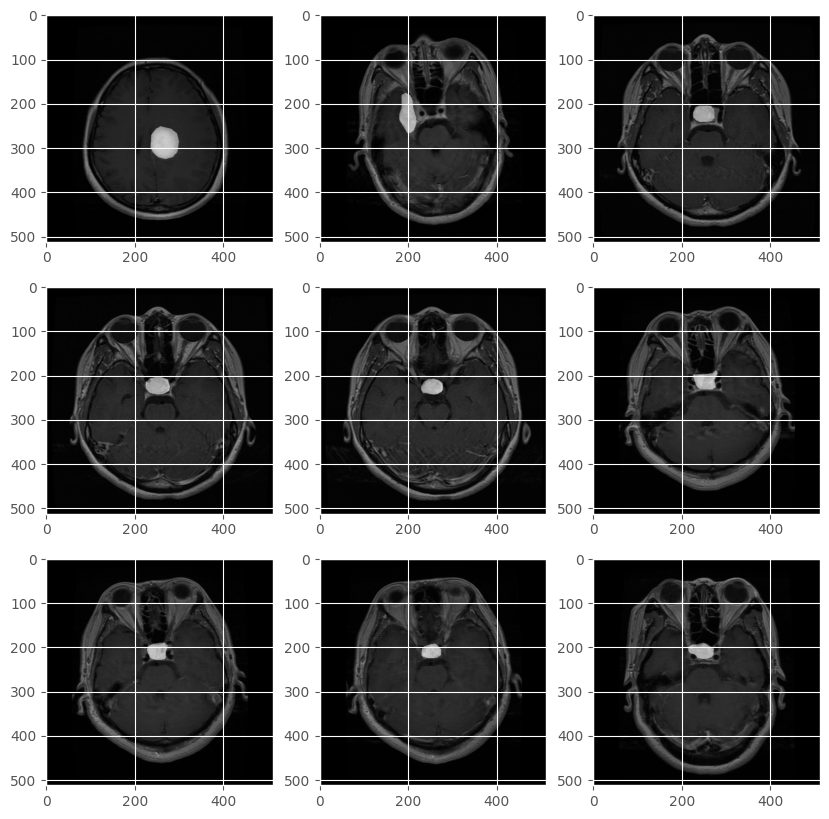

In [6]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [7]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(725, 2)
(182, 2)
(101, 2)


In [8]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)


In [9]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [10]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [11]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['activation[0][0]']          
                                                                                              

In [12]:
EPOCHS = 20
BATCH_SIZE = 32
learning_rate = 0.0001

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define the learning rate and number of epochs
# learning_rate = 0.001  # Adjust this based on your needs
# EPOCHS = 50  # Adjust the number of epochs as needed

# Create generators for training and validation data
train_generator_args = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_generator(df_train, BATCH_SIZE, train_generator_args, target_size=(im_height, im_width))
test_gen = train_generator(df_val, BATCH_SIZE, dict(), target_size=(im_height, im_width))

# Create UNet model
model = unet(input_size=(im_height, im_width, 3))

# Calculate decay steps for learning rate decay (optional)
decay_steps = len(df_train) // BATCH_SIZE * EPOCHS

# Define learning rate schedule using ExponentialDecay
lr_schedule = ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=0.95,  # Adjust decay rate as needed
    staircase=True
)

# Create Adam optimizer with custom learning rate schedule
opt = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

# Compile the model with custom optimizer, loss function, and metrics
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

# Define callbacks (e.g., ModelCheckpoint to save the best model)
callbacks = [ModelCheckpoint('unet_brain_mri_seg.keras', verbose=1, save_best_only=True)]

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(df_train) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=test_gen,
    validation_steps=len(df_val) // BATCH_SIZE
)


Found 725 validated image filenames.
Found 725 validated image filenames.
Epoch 1/20
22/22 [==============================] - ETA: 0s - loss: -0.0777 - binary_accuracy: 0.6306 - iou: 0.0406 - dice_coef: 0.0777 Found 182 validated image filenames.
Found 182 validated image filenames.

Epoch 1: val_loss improved from inf to -0.03848, saving model to unet_brain_mri_seg.keras
22/22 [==============================] - 443s 17s/step - loss: -0.0777 - binary_accuracy: 0.6306 - iou: 0.0406 - dice_coef: 0.0777 - val_loss: -0.0385 - val_binary_accuracy: 0.5168 - val_iou: 0.0197 - val_dice_coef: 0.0385
Epoch 2/20
22/22 [==============================] - ETA: 0s - loss: -0.1231 - binary_accuracy: 0.8734 - iou: 0.0656 - dice_coef: 0.1226
Epoch 2: val_loss improved from -0.03848 to -0.03909, saving model to unet_brain_mri_seg.keras
22/22 [==============================] - 90s 2s/step - loss: -0.1231 - binary_accuracy: 0.8734 - iou: 0.0656 - dice_coef: 0.1226 - val_loss: -0.0391 - val_binary_accuracy:

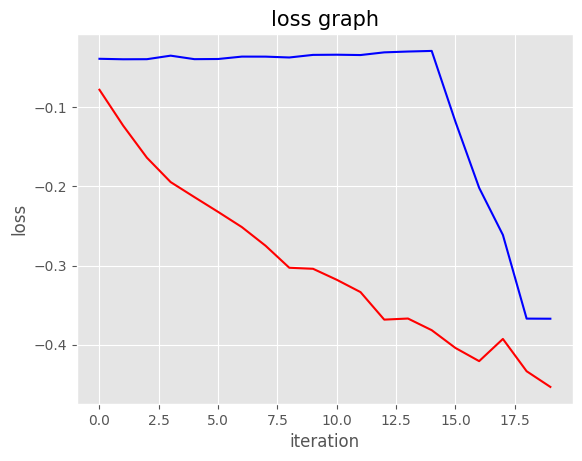

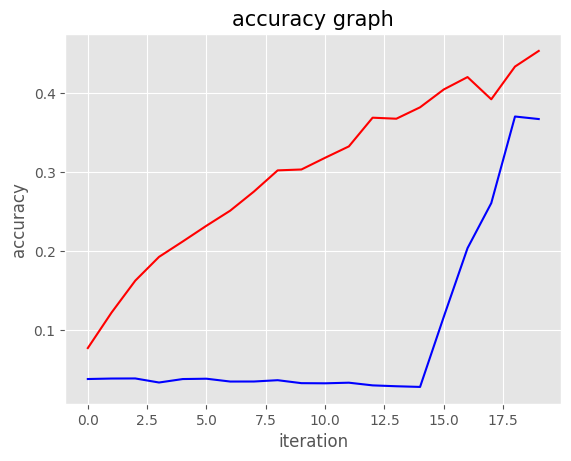

In [14]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [15]:
model = load_model('unet_brain_mri_seg.keras', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [16]:
import math

# Assuming df_test contains information about test data (file paths, labels, etc.)

# Create test generator with appropriate parameters
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width))

# Calculate the number of steps (batches) for evaluation
total_samples = len(df_test)
steps = math.ceil(total_samples / BATCH_SIZE)  # Ensure steps is an integer

# Evaluate the model on the test generator
results = model.evaluate(test_gen, steps=steps)

# Print evaluation results
print("Test Loss:", results[0])
print("Test IOU:", results[1])
print("Test Dice Coefficient:", results[2])


Found 101 validated image filenames.
Found 101 validated image filenames.
4/4 [==============================] - 34s 11s/step - loss: -0.3989 - binary_accuracy: 0.9896 - iou: 0.2377 - dice_coef: 0.3819


1/1 [==============================] - 3s 3s/step


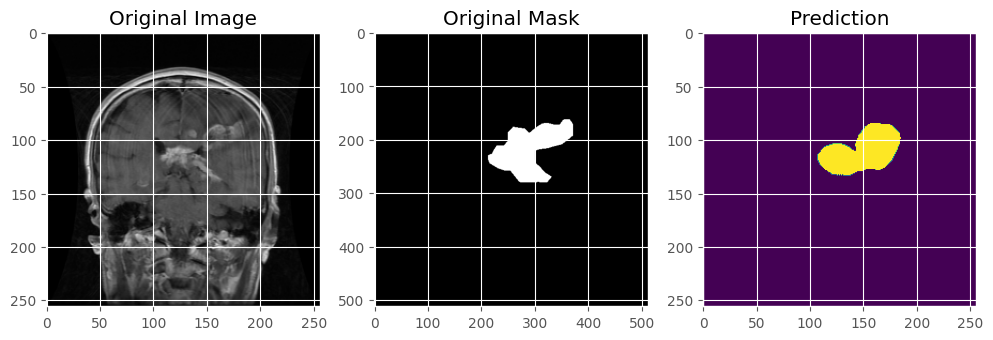

1/1 [==============================] - 0s 24ms/step


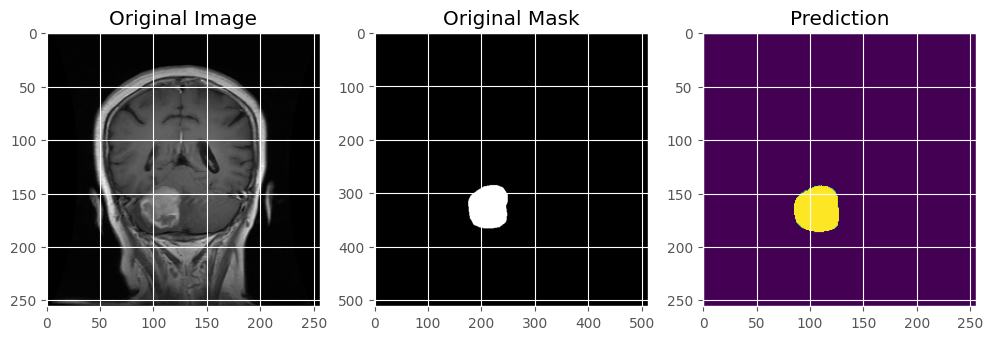

1/1 [==============================] - 0s 26ms/step


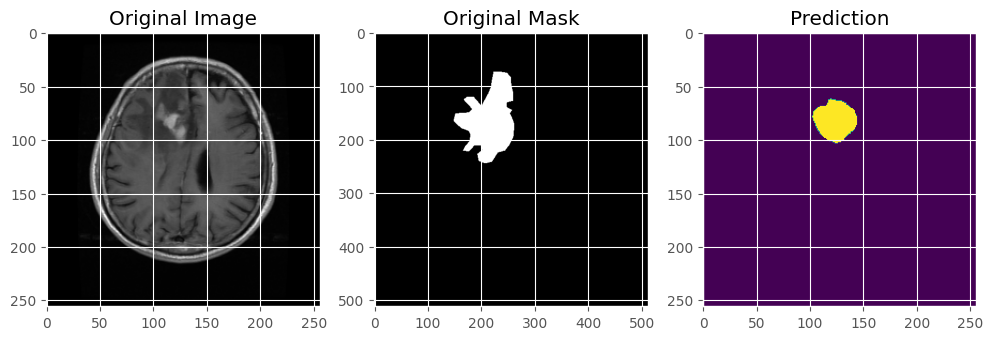

1/1 [==============================] - 0s 23ms/step


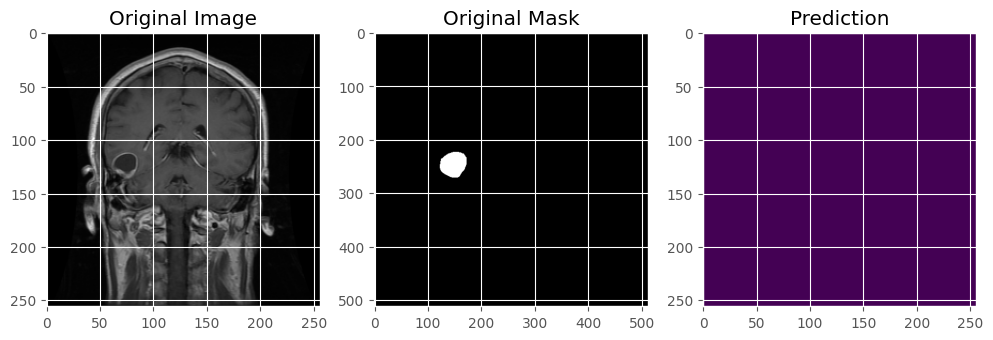

1/1 [==============================] - 0s 42ms/step


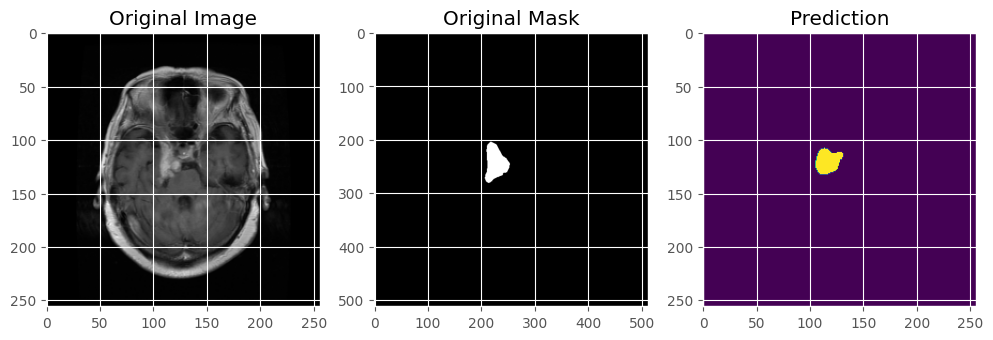

1/1 [==============================] - 0s 23ms/step


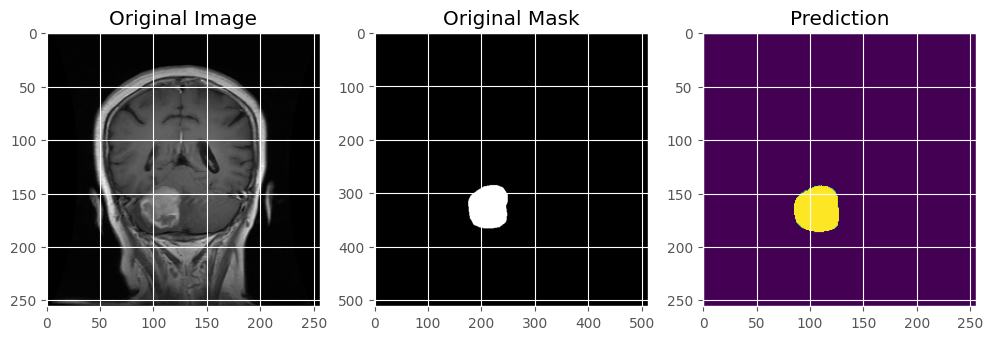

1/1 [==============================] - 0s 22ms/step


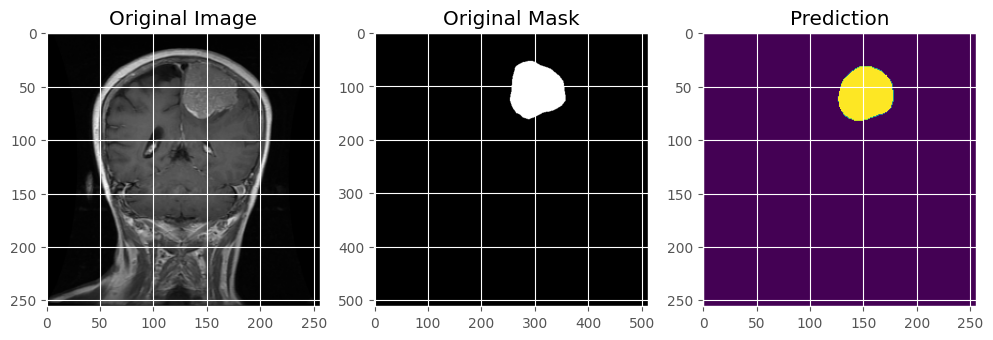

1/1 [==============================] - 0s 23ms/step


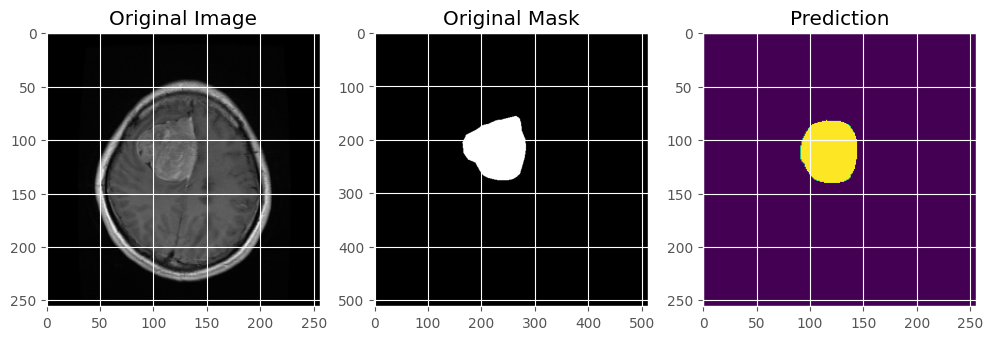

1/1 [==============================] - 0s 34ms/step


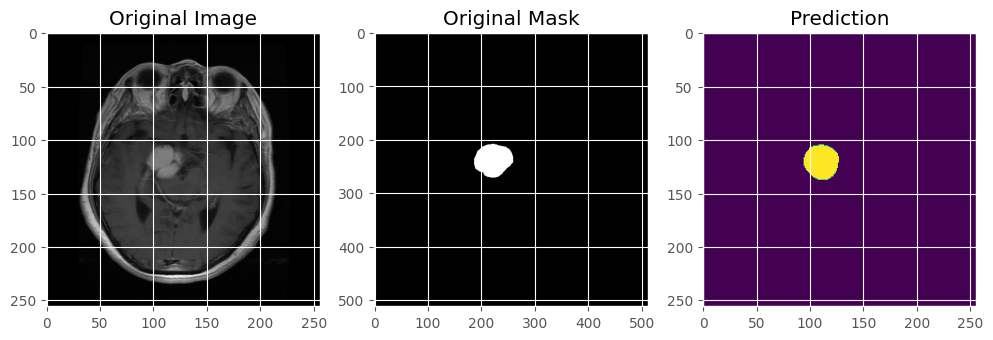

1/1 [==============================] - 0s 34ms/step


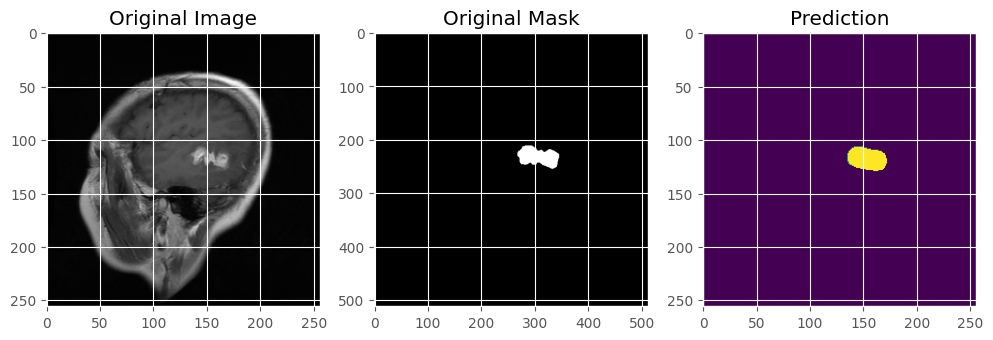

1/1 [==============================] - 0s 39ms/step


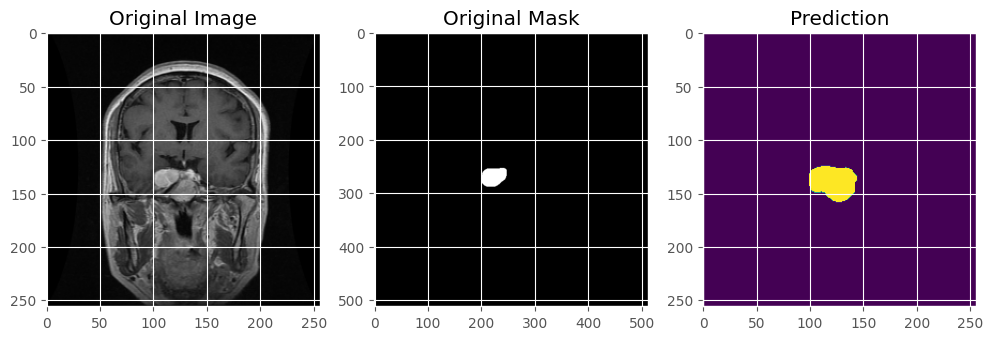

1/1 [==============================] - 0s 43ms/step


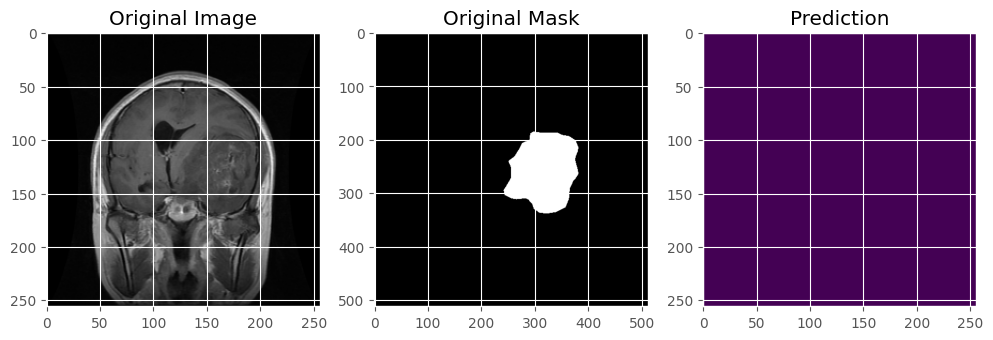

1/1 [==============================] - 0s 29ms/step


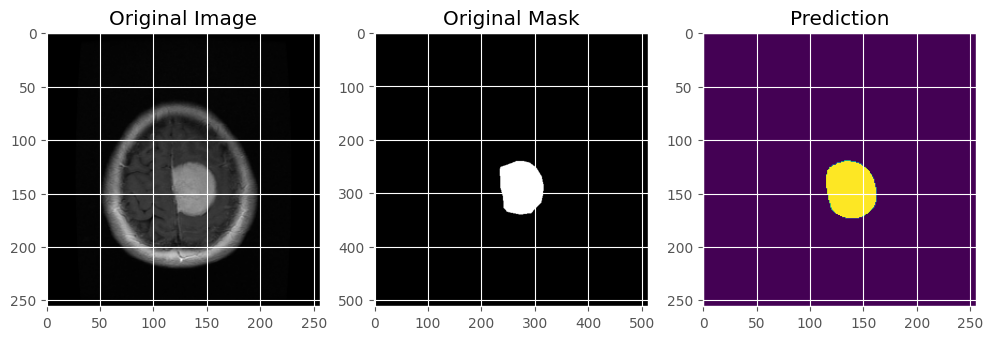

1/1 [==============================] - 0s 23ms/step


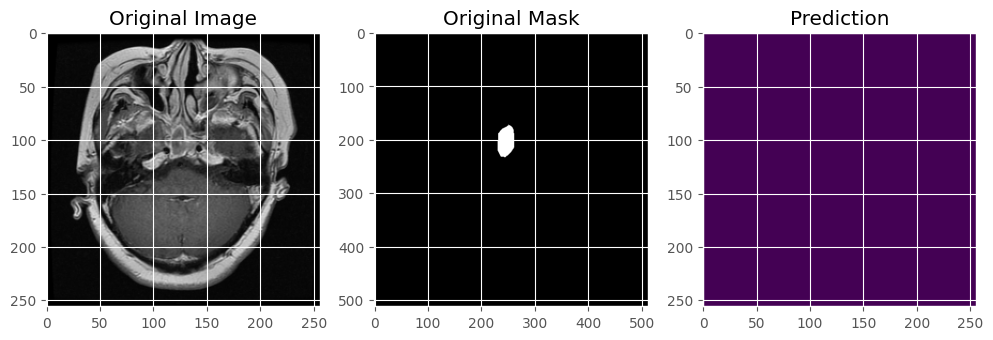

1/1 [==============================] - 0s 22ms/step


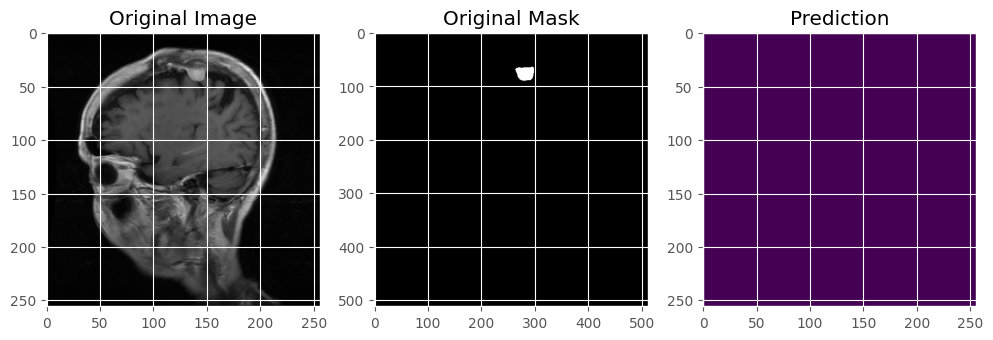

1/1 [==============================] - 0s 26ms/step


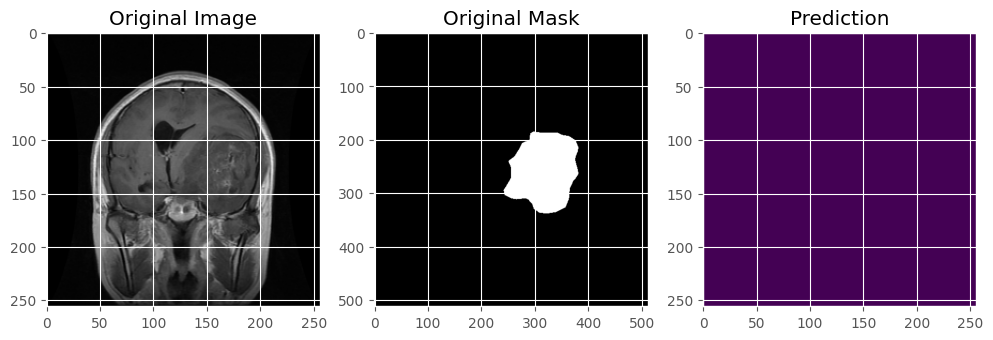

1/1 [==============================] - 0s 23ms/step


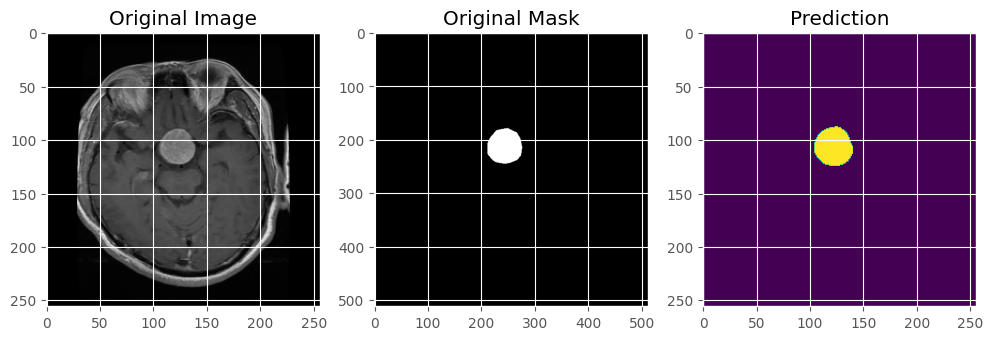

1/1 [==============================] - 0s 24ms/step


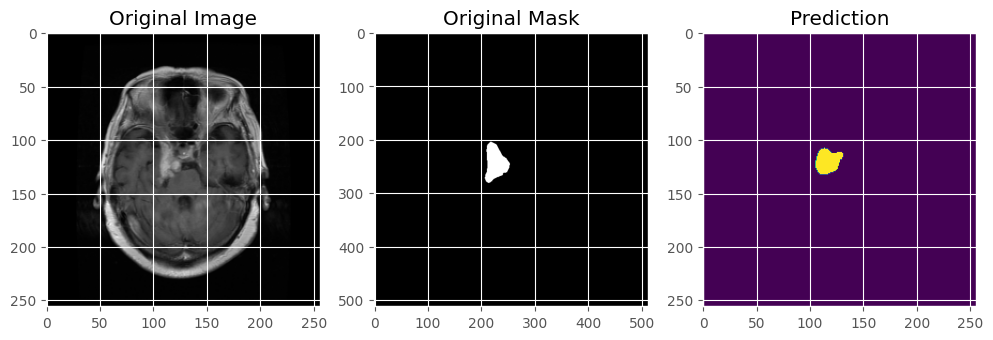

1/1 [==============================] - 0s 22ms/step


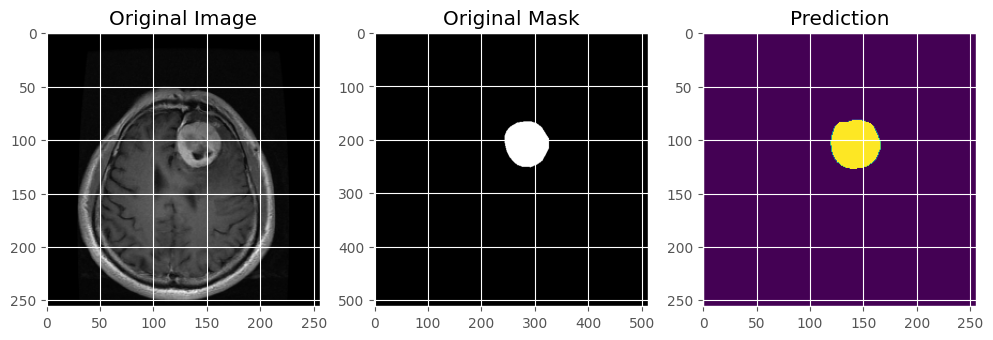

1/1 [==============================] - 0s 22ms/step


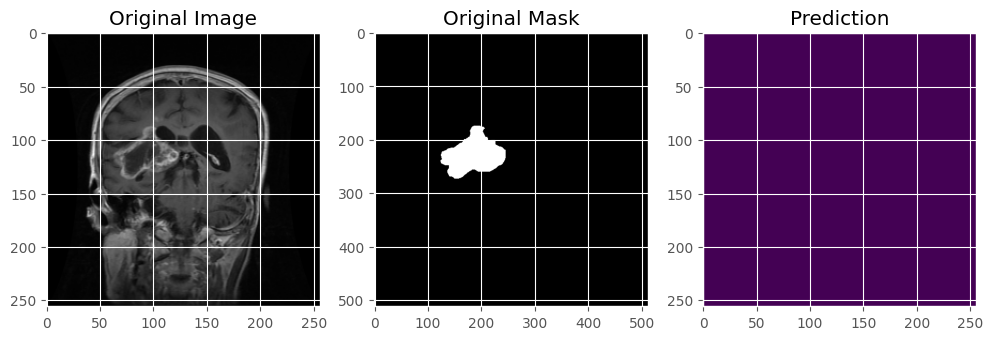

1/1 [==============================] - 0s 24ms/step


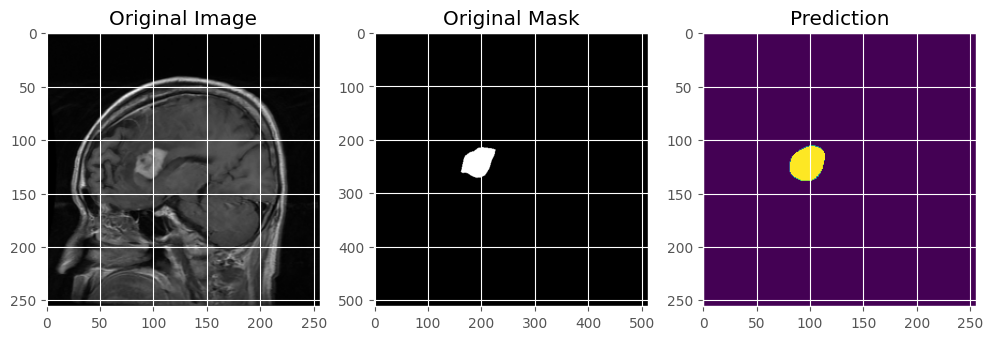

1/1 [==============================] - 0s 30ms/step


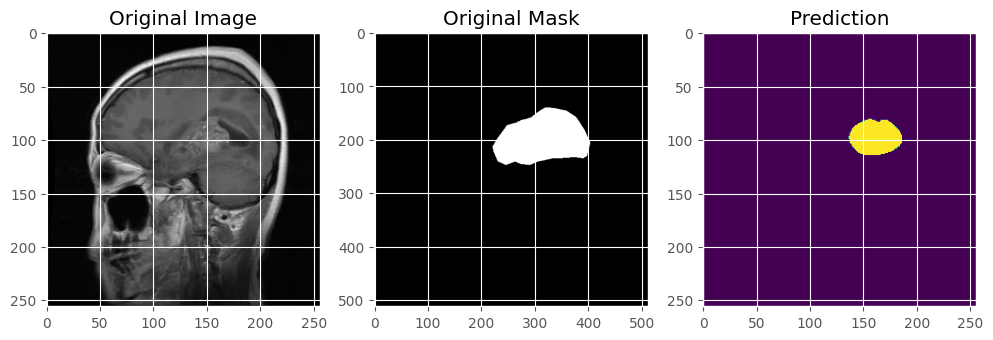

1/1 [==============================] - 0s 23ms/step


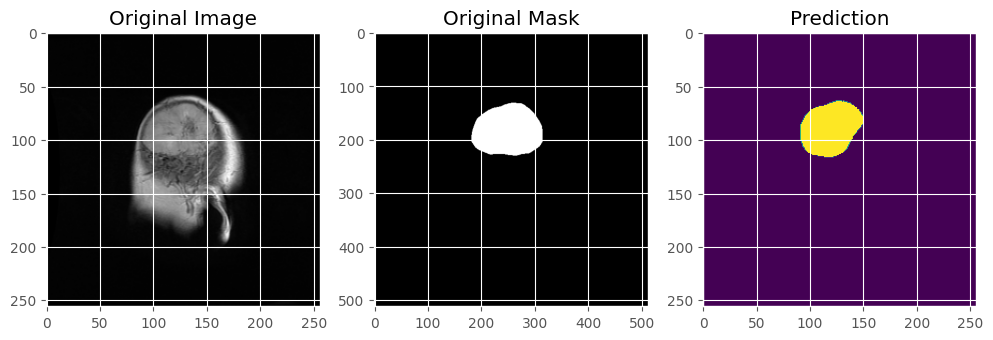

1/1 [==============================] - 0s 22ms/step


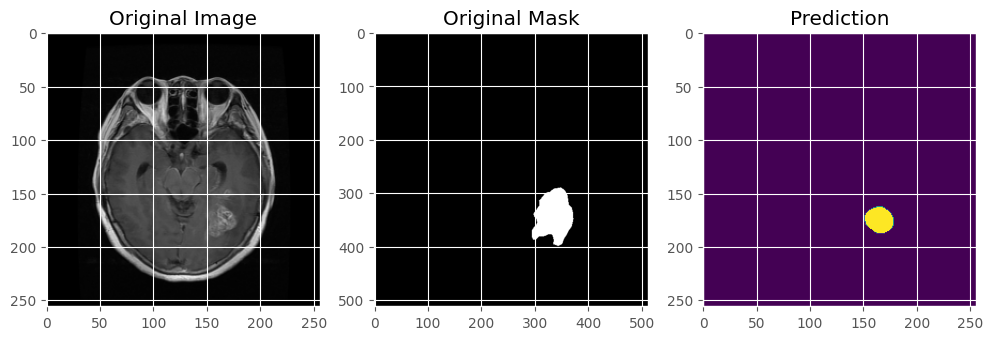

1/1 [==============================] - 0s 32ms/step


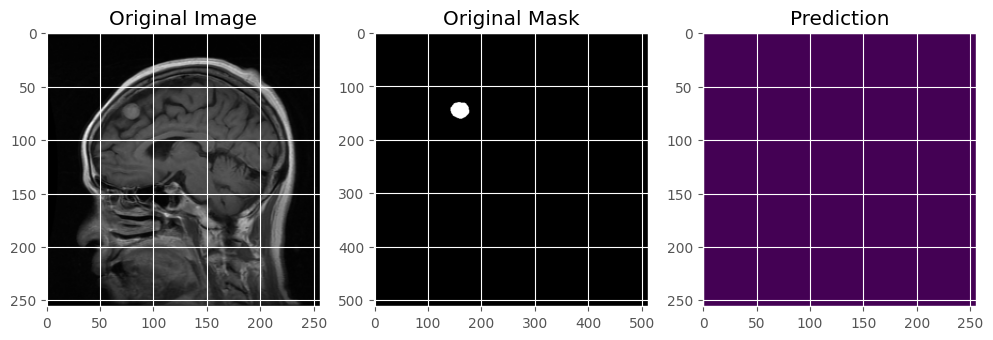

1/1 [==============================] - 0s 35ms/step


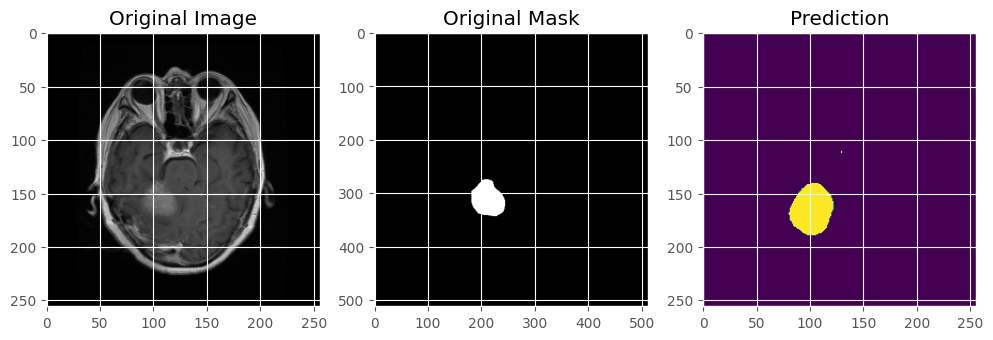

1/1 [==============================] - 0s 65ms/step


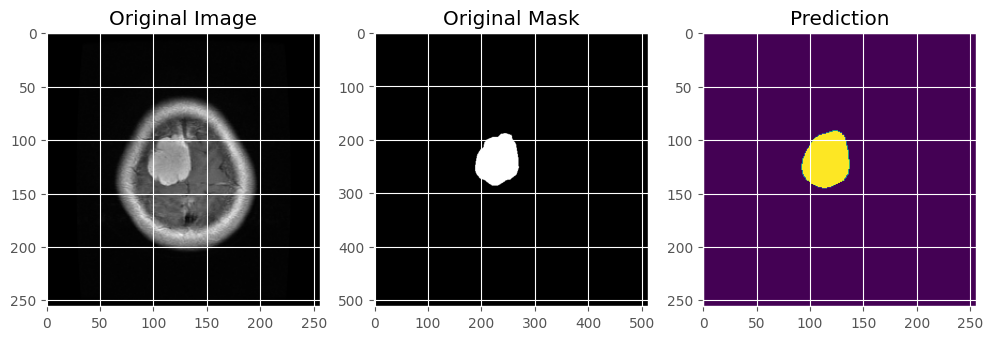

1/1 [==============================] - 0s 23ms/step


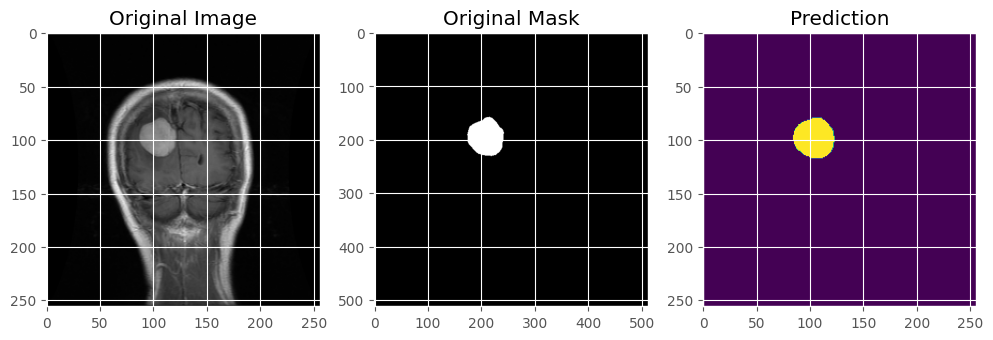

1/1 [==============================] - 0s 23ms/step


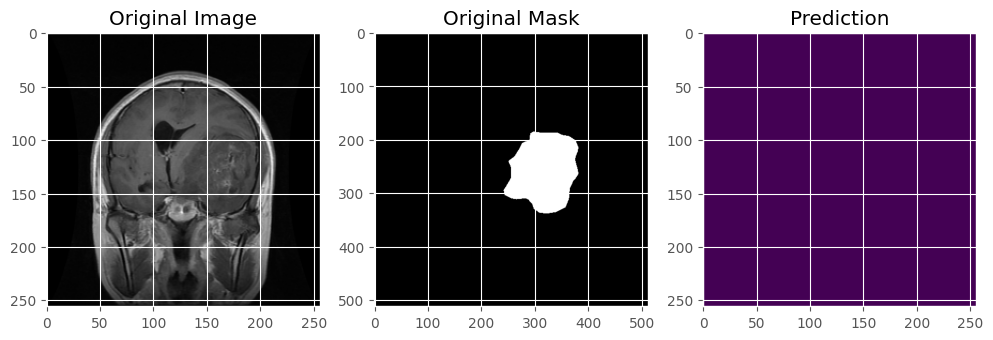

1/1 [==============================] - 0s 24ms/step


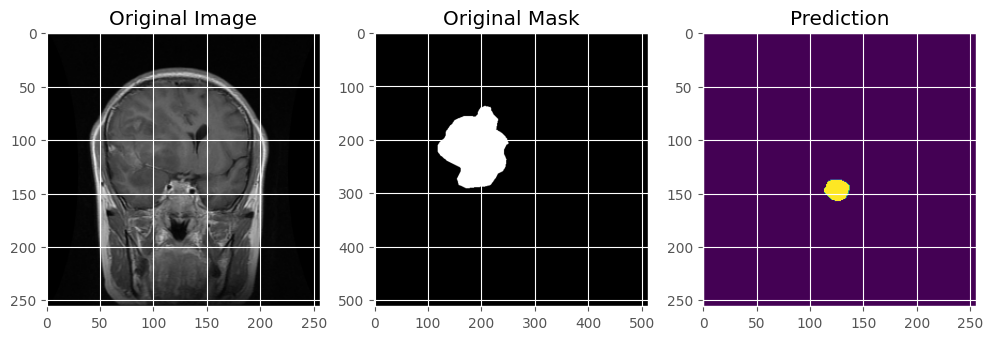

In [17]:

for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

In [ ]:
# from IPython.display import FileLink
# FileLink('./unet_brain_mri_seg.hdf5')

1/1 [==============================] - 3s 3s/step


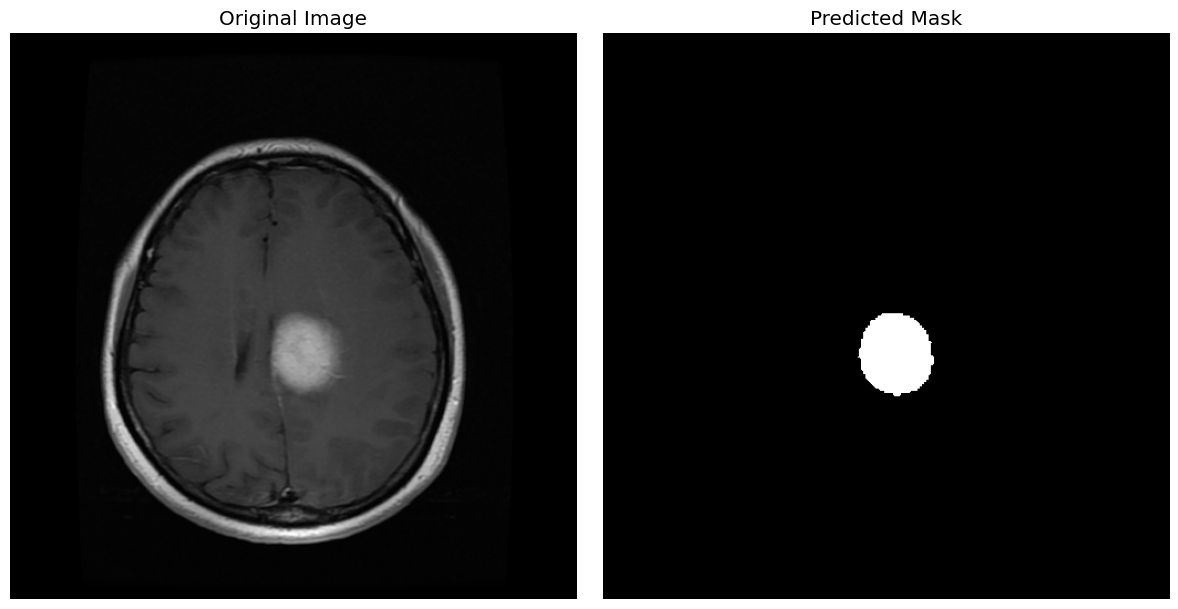

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def preprocess_image(image_path, input_shape=(240, 240)):
    # Load the image using OpenCV (assuming BGR format)
    image = cv2.imread(image_path)

    # Resize the image to the specified input dimensions
    resized_image = cv2.resize(image, input_shape)

    # Normalize pixel values to the range [0, 1]
    normalized_image = resized_image.astype('float32') / 255.0

    # Add batch dimension to match the model input shape (1, height, width, channels)
    preprocessed_image = normalized_image[None, ...]

    return preprocessed_image

def postprocess_mask(predicted_mask, original_shape, threshold=0.5):
    # Apply thresholding to convert the predicted mask to a binary mask
    binary_mask = (predicted_mask > threshold).astype(np.uint8)

    # Resize the binary mask to the original image dimensions
    resized_mask = cv2.resize(binary_mask[0], (original_shape[1], original_shape[0]))

    # Apply morphological operations (e.g., opening, closing) to refine the mask
    kernel = np.ones((5, 5), np.uint8)
    processed_mask = cv2.morphologyEx(resized_mask, cv2.MORPH_CLOSE, kernel)

    return processed_mask

def show_images(original_image, predicted_mask, title1=None, title2=None):
    # Display the original image and predicted mask using Matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display original image
    axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title(title1 if title1 else 'Original Image')
    axes[0].axis('off')

    # Display predicted mask
    axes[1].imshow(predicted_mask, cmap='gray')
    axes[1].set_title(title2 if title2 else 'Predicted Mask')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Specify the path to the new image
new_image_path = "/content/drive/MyDrive/img _msk_red/images/10.png"

# Preprocess the new image for prediction
preprocessed_image = preprocess_image(new_image_path)

# Use the trained model for segmentation prediction
predicted_mask = model.predict(preprocessed_image)

# Get the original shape of the image before resizing
original_image = cv2.imread(new_image_path)

# Post-process the predicted mask (provide the original shape of the image)
original_shape = original_image.shape[:2]
segmented_mask = postprocess_mask(predicted_mask, original_shape)

# Display the original image and predicted mask side by side
show_images(original_image, segmented_mask, title1='Original Image', title2='Predicted Mask')


1/1 [==============================] - 0s 35ms/step


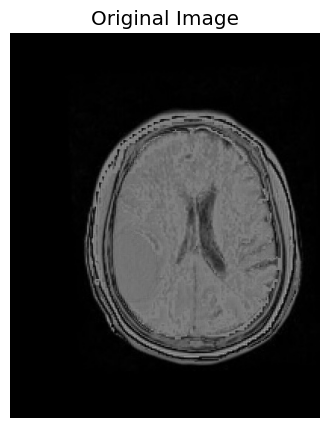

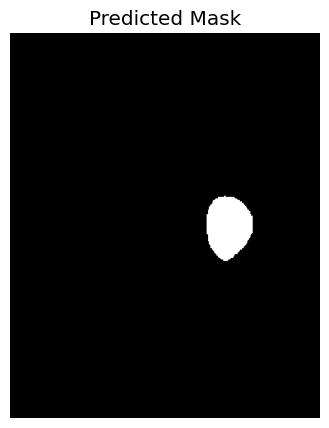

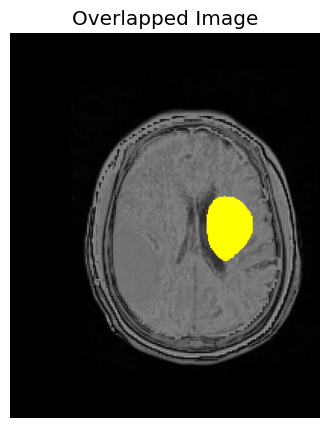

In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def preprocess_image(image_path, input_shape=(240, 240)):
    # Load the image using OpenCV (assuming BGR format)
    image = cv2.imread(image_path)

    # Resize the image to the specified input dimensions
    resized_image = cv2.resize(image, input_shape)

    # Normalize pixel values to the range [0, 1]
    normalized_image = resized_image.astype('float32') / 255.0

    # Add batch dimension to match the model input shape (1, height, width, channels)
    preprocessed_image = normalized_image[None, ...]

    return preprocessed_image

def postprocess_mask(predicted_mask, original_shape, threshold=0.5):
    # Apply thresholding to convert the predicted mask to a binary mask
    binary_mask = (predicted_mask > threshold).astype(np.uint8)

    # Resize the binary mask to the original image dimensions
    resized_mask = cv2.resize(binary_mask[0], (original_shape[1], original_shape[0]))

    # Apply morphological operations (e.g., opening, closing) to refine the mask
    kernel = np.ones((5, 5), np.uint8)
    processed_mask = cv2.morphologyEx(resized_mask, cv2.MORPH_CLOSE, kernel)

    return processed_mask

def show_original_image(image, title="Original Image", figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title)
    plt.show()

def show_mask(mask, title="Mask", figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(mask, cmap='gray')  # Display mask in grayscale
    plt.axis('off')
    plt.title(title)
    plt.show()

def show_overlaid_image(image, mask, alpha=0.4, title="Overlapped Image", figsize=(5, 5)):
    overlaid_image = image.copy()
    overlaid_image[mask > 0] = [0, 255, 255]  # Set pixels where mask is non-zero to light yellow
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(overlaid_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title)
    plt.show()

# Specify the path to the new image
new_image_path = "/content/drive/MyDrive/Fused/Fused/images/15_MR_s1.jpg"

# Preprocess the new image for prediction
preprocessed_image = preprocess_image(new_image_path)

# Use the trained model for segmentation prediction
predicted_mask = model.predict(preprocessed_image)

# Get the original shape of the image before resizing
original_image = cv2.imread(new_image_path)

# Post-process the predicted mask (provide the original shape of the image)
original_shape = original_image.shape[:2]
segmented_mask = postprocess_mask(predicted_mask, original_shape)

# Display the original image, predicted mask, and overlaid image
show_original_image(original_image, title="Original Image")
show_mask(segmented_mask, title="Predicted Mask")
show_overlaid_image(original_image, segmented_mask, title="Overlapped Image")
